In [1]:
# Building a basic selector ML algorithm for picking simulation strategy with inferQ data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import * 

In [3]:
FEATURES = [
    # Circuit size & structure
    "num_qubits",
    # "circuit_qubits",
    "width",
    "depth",
    # "circuit_depth",
    "circuit_size",
    # "gate_counts",
    "pauli_gate_count",
    "two_qubit_gate_count",
    "two_qubit_gate_percentage",
    # "transpiled_depth",
    # "transpiled_size",
    # "transpiled_qubits",

    # Graph features
    "igdepth",
    "node_count",
    "edge_count",
    "average_degree",
    "max_degree",
    "average_shortest_path_length",
    "average_clustering_coefficient",
    "diameter",
    "radius",
    # "pagerank",
    # # "core_number",
    # # "connected_components",
    "central_point_of_dominance",
    "density_score",
    "std_dev_adjacency_matrix",
    "min_cut_upper",

    # Sparsity / locality
    # "sparsity",
    "locality_ratio",
    "idling_score",
    # "statevector_entropy",
    "statevector_saved_entropy",
    "statevector_saved_sparsity",
]

METHODS = [
    # "statevector_saved",
    "statevector",
    # "stabilizer",
    "density_matrix",
    "matrix_product_state",
    "extended_stabilizer",
    "unitary",
    # "automatic"
]

In [4]:
# df = df.replace(
#     ["none", "None", "NONE", "", "null", "NULL"],
#     np.nan
# )

# missing = (
#     df[FEATURES + [f"{m}_execution_time" for m in METHODS] + [f"{m}_memory_usage" for m in METHODS]]
#     # df[FEATURES]
#     .isna()
#     .sum()
#     .to_frame("missing_count")
# )

# missing["missing_fraction"] = missing["missing_count"] / len(df)
# missing = missing.sort_values("missing_count", ascending=False)

# print(missing)


In [5]:
# before = len(df)
# # df_dropped = df.dropna(subset=(FEATURES+[f"{m}_execution_time" for m in METHODS] + [f"{m}_memory_usage" for m in METHODS]))
# df_dropped = df.dropna(subset=(FEATURES + ["automatic_execution_time", "automatic_memory_usage"]))
# after = len(df_dropped)

# print(f"Rows kept: {after/before:.2%}")
# print(after)

In [6]:

# df_dropped = df_dropped.dropna(subset=[f"{m}_execution_time" for m in METHODS])
# print(len(df_dropped))

In [7]:
df_dropped = pd.read_csv("data_clean_sim_auto_worked.csv")

In [8]:
def best_method(row):
    costs = {}
    for m in METHODS:
        t = row.get(f"{m}_execution_time")
        mem = row.get(f"{m}_memory_usage")
        if pd.isna(t) or pd.isna(mem):
            continue
        costs[m] = t
    return min(costs, key=costs.get) if costs else np.nan

df_dropped["best_method"] = df_dropped.apply(best_method, axis=1)
df_clean = df_dropped.dropna(subset=["best_method"])
print(len(df_clean))

25799


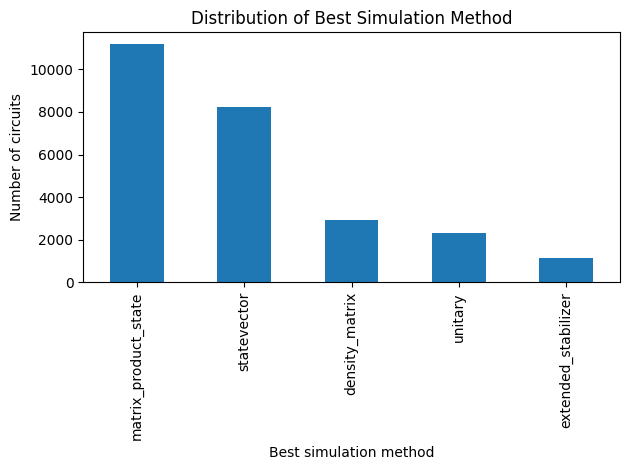

In [9]:
import matplotlib.pyplot as plt

df_clean["best_method"].value_counts().plot(kind="bar")

plt.xlabel("Best simulation method")
plt.ylabel("Number of circuits")
plt.title("Distribution of Best Simulation Method")
plt.tight_layout()
plt.show()


In [10]:
total = len(df_clean)
print(df_clean["best_method"].value_counts())
print(len(df_clean))
print(df_clean["best_method"].value_counts()/total)

best_method
matrix_product_state    11178
statevector              8254
density_matrix           2936
unitary                  2311
extended_stabilizer      1120
Name: count, dtype: int64
25799
best_method
matrix_product_state    0.433273
statevector             0.319935
density_matrix          0.113803
unitary                 0.089577
extended_stabilizer     0.043413
Name: count, dtype: float64


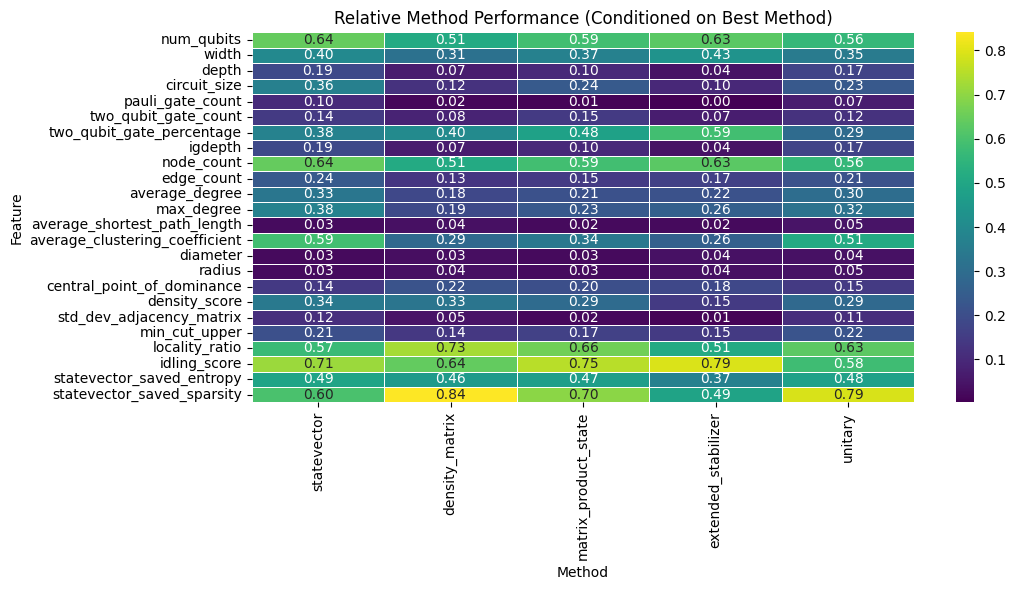

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

matrix = pd.DataFrame(index=FEATURES, columns=METHODS, dtype=float)

for method in METHODS:
    subset = df_clean[df_clean["best_method"] == method]
    for feature in FEATURES:
        mx, mi = subset[feature].max(),subset[feature].min()
        if mx - mi > 0:
            matrix.loc[feature, method] = (subset[feature].mean()-mi)/(mx-mi)
        else:
            matrix.loc[feature, method] = 0.0

# --- Min–max normalize per feature (row-wise) ---
matrix_norm = matrix.copy()

# --- Plot heatmap ---
plt.figure(figsize=(11, 6))
sns.heatmap(
    matrix_norm,
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=0.5
)

plt.title("Relative Method Performance (Conditioned on Best Method)")
plt.xlabel("Method")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Best Method Histograms

In [12]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from utils import *

# plot_best_method_hists(METHODS, FEATURES, df_clean)


In [13]:
X = df_clean[FEATURES].select_dtypes(include=[np.number])
y = df_clean["best_method"]

# PCA 

# Random Forest 

In [14]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

TARGET = "best_method"
RANDOM_STATE = 42

X = df_clean[FEATURES]
y = df_clean[TARGET]

y_original = df_clean[TARGET]


X_train, X_test, y_train, y_test, y_orig_train, y_orig_test = train_test_split(
    X, y, y_original,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)


                      precision    recall  f1-score   support

         statevector       0.86      0.48      0.62      1651
      density_matrix       0.40      0.52      0.45       587
matrix_product_state       0.61      0.82      0.70      2236
 extended_stabilizer       0.61      0.42      0.50       224
             unitary       0.52      0.35      0.42       462

            accuracy                           0.62      5160
           macro avg       0.60      0.52      0.54      5160
        weighted avg       0.66      0.62      0.61      5160



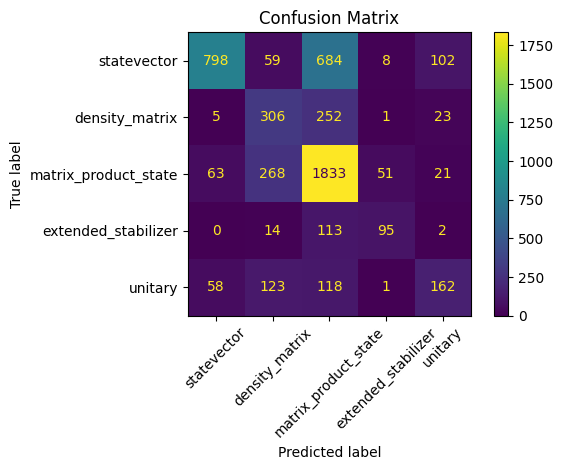

In [15]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(
    y_test, y_pred,
    labels=METHODS,
    target_names = METHODS
))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    labels=METHODS,
    xticks_rotation=45
)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# XG Boost

                      precision    recall  f1-score   support

      density_matrix       0.40      0.43      0.41       587
 extended_stabilizer       0.57      0.55      0.56       224
matrix_product_state       0.62      0.77      0.68      2236
         statevector       0.75      0.53      0.62      1651
             unitary       0.45      0.37      0.41       462

            accuracy                           0.61      5160
           macro avg       0.56      0.53      0.54      5160
        weighted avg       0.62      0.61      0.60      5160



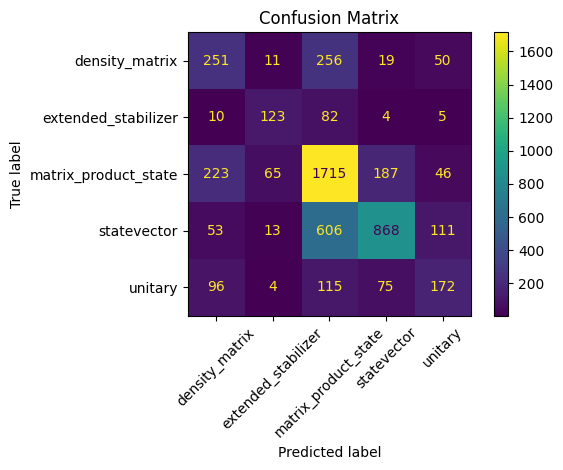

In [16]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

num_classes = len(le.classes_)

model = XGBClassifier(
    n_estimators=400,
    max_depth=12,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=10,
    objective="multi:softmax",   # softmax since we want class labels
    num_class=num_classes,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    eval_metric="mlogloss"
)

model.fit(X_train, y_train_enc)

y_pred_enc = model.predict(X_test)

y_pred = le.inverse_transform(y_pred_enc)

print(classification_report(
    y_test,
    y_pred,
    labels=le.classes_,
    target_names=le.classes_
))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    labels=le.classes_,
    xticks_rotation=45
)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# SVC 

In [17]:
# from sklearn.svm import SVC

# model = SVC(
#     kernel="rbf",
#     C=10.0,
#     gamma="scale",
#     class_weight="balanced",
#     random_state=RANDOM_STATE
# )

# model.fit(X_train, y_train_enc)

# y_pred_enc = model.predict(X_test)
# y_pred = le.inverse_transform(y_pred_enc)

# print(classification_report(
#     y_test,
#     y_pred,
#     labels=le.classes_,
#     target_names=le.classes_
# ))
# ConfusionMatrixDisplay.from_predictions(
#     y_test,
#     y_pred,
#     labels=le.classes_,
#     xticks_rotation=45
# )
# plt.title("SVM Confusion Matrix")
# plt.tight_layout()
# plt.show()

In [18]:
# Now let us compare against the accuracy of automatic
METHODS.append("automatic")

df_auto = df_dropped
print(len(df_auto))

df_auto["best_method"] = df_auto.apply(best_method, axis=1)
df_auto = df_auto.dropna(subset=["best_method"])

total = len(df_auto)

counts = df_auto["best_method"].value_counts()
percentages = counts / total * 100
summary_df = pd.DataFrame({
    "count": counts,
    "percentage": percentages
})
print(summary_df)
METHODS.remove("automatic")

25799
                      count  percentage
best_method                            
automatic              9714   37.652622
matrix_product_state   7944   30.791891
statevector            3855   14.942440
density_matrix         2214    8.581728
unitary                1447    5.608745
extended_stabilizer     625    2.422575
